#### SinText: Text Removal with U-Net
_Yoav Rabinovich, July 2020_

----------------------------------------

U-Net trained on pictures stamped with random text using F1 pixel loss and using transfer learning from a pretrained resnet 34 is able to remove text from pictures and reliably fill in contextual information, but prone to overfitting.

An attempt to aleviate this using feature loss, which scores the network based on the activations of pretrained classifier (vgg16) of a classifier to enforce a more general similarity metric has failed, as the U-Net is able to fool the feature loss network by simply changing the color of the text (as evidenced by low feature loss attained by altered color results). 

Based on Fastai course lesson 7, which used a U-Net with feature loss for super-resolution.

In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

In [ ]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *

from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw 

from torchvision.models import vgg16_bn

import warnings
warnings.filterwarnings('ignore')

In [ ]:
path = untar_data(URLs.PETS)
original = path/'images'
processed = path/'small-256'
processed_s = path/'small-256-stamped'

il = ImageList.from_folder(original)

In [ ]:
def random_string(length):
    A, z = np.array(["A","z"]).view("int32")
    return str(np.random.randint(low=A,high=z,size=length,dtype="int32").view(f"U{length}"))

def process(fn, i, size, path, stamp):
    dest = path/fn.relative_to(original)
    dest.parent.mkdir(parents=True, exist_ok=True)
    img = PIL.Image.open(fn)
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
    if stamp:
        draw = ImageDraw.Draw(img)
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationMono-Regular.ttf", np.random.randint(int(size/10),int(size/2)))
        draw.text(tuple(np.random.randint(0,size,2)),random_string(np.random.randint(2,10)),tuple(np.random.randint(0,255,3)),font=font)
    img.save(dest, quality=60)

In [ ]:
sets = [(processed, 256, False), (processed_s, 256, True)]
for p,size,stamp in sets:
    if not p.exists():
        print(f"processing to {size} into {p}")
        parallel(partial(process, path=p, size=size, stamp=stamp), il.items)

In [ ]:
bs,size=12,256
arch = models.resnet34
src = ImageImageList.from_folder(processed_s).split_by_rand_pct(0.1, seed=42)

In [ ]:
def get_data(bs,size):
    data = (src.label_from_func(lambda x: processed/x.name)
           .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
           .databunch(bs=bs).normalize(imagenet_stats, do_y=True))

    data.c = 3
    return data

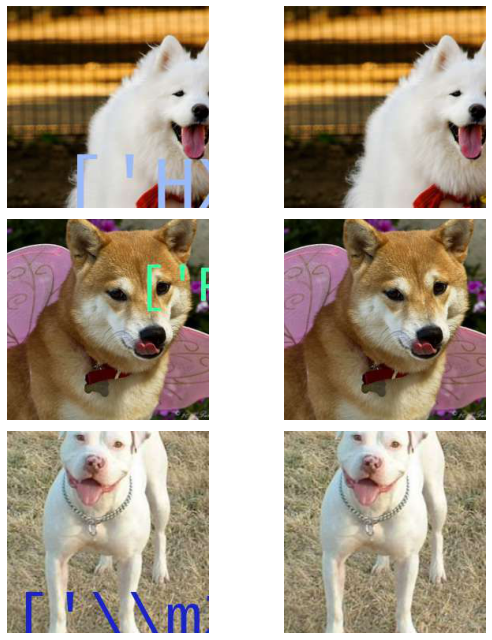

In [ ]:
data = get_data(bs,size)
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

In [ ]:
base_loss = F.l1_loss

In [ ]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=base_loss,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


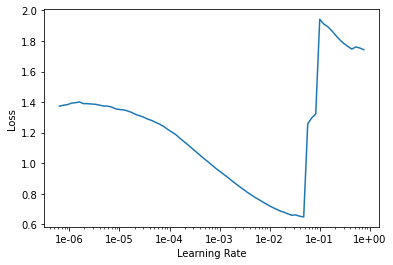

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 1e-3

In [ ]:
def do_fit(learner,save_name, epochs, lrs=slice(lr), pct_start=0.9):
    learner.fit_one_cycle(epochs, lrs, pct_start=pct_start)
    learner.save(save_name)
    learner.show_results(rows=5, imgsize=3)

epoch,train_loss,valid_loss,time
0,0.062344,0.062774,05:06
1,0.058069,0.066636,04:59
2,0.046776,0.049116,04:57
3,0.030216,0.028242,04:58
4,0.017926,0.017827,04:57


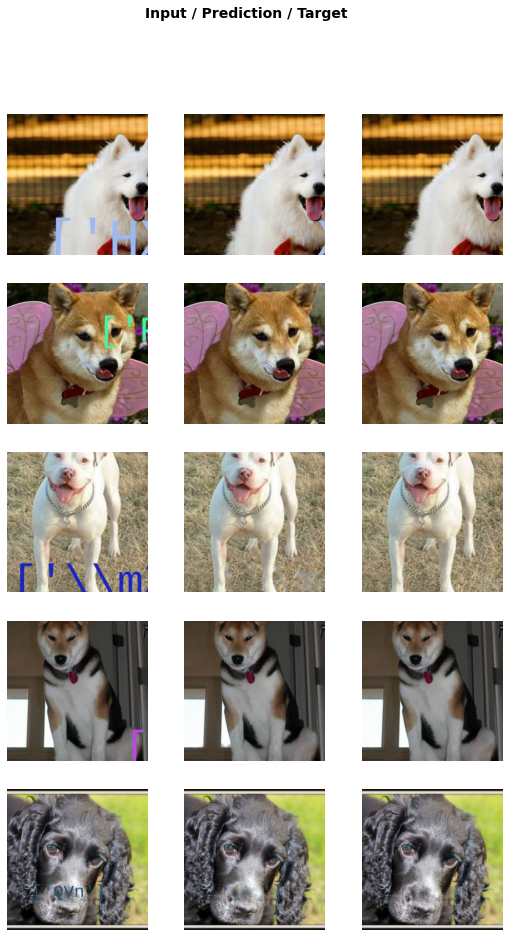

In [ ]:
do_fit(learn, '1a', 5, slice(lr*10))

epoch,train_loss,valid_loss,time
0,0.016229,0.017530,05:14
1,0.015393,0.017312,05:14
2,0.015705,0.016897,05:14
3,0.015289,0.016180,05:14
4,0.014282,0.015568,05:14


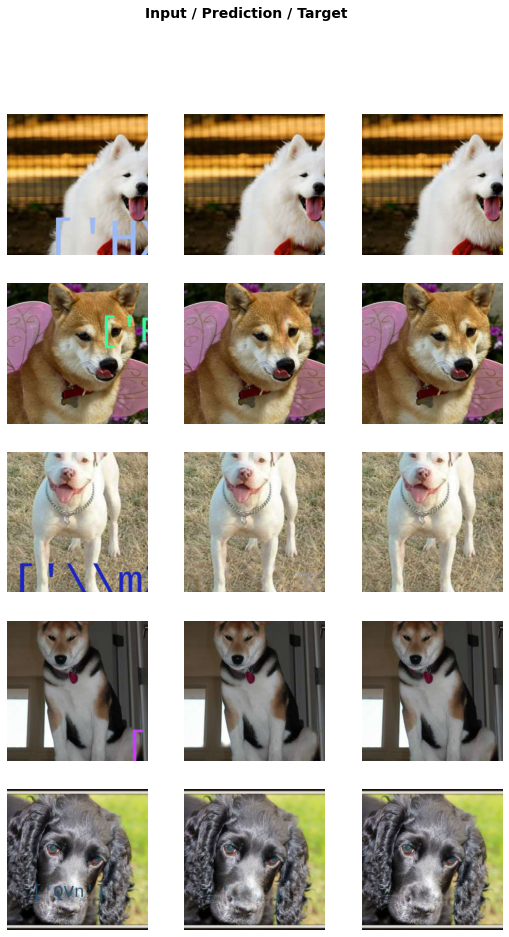

In [ ]:
learn.unfreeze()
do_fit(learn, '1b', 5, slice(1e-5,lr))

In [ ]:
def compare(learner, url):
    im = open_image(requests.get(url, stream=True).raw)
    pred = learner.predict(im)
    im.show()
    pred[0].show(figsize=(5,5),title="Predicted")

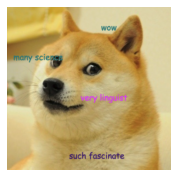

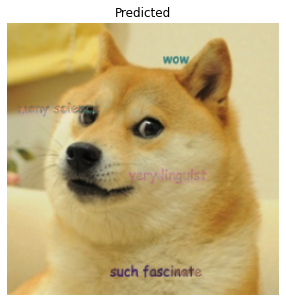

In [ ]:
compare(learn, "https://blogs.unimelb.edu.au/sciencecommunication/files/2016/10/my-doge-zzb6qh-300x300.png")

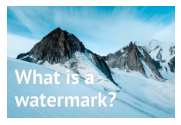

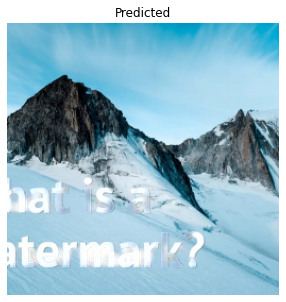

In [ ]:
compare(learn,"https://www.visualwatermark.com/images/posts/what-is-a-watermark.jpg")

In [ ]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

In [ ]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [ ]:
learn2 = unet_learner(data, arch, wd=wd, loss_func=feat_loss, callback_fns=LossMetrics,
                     blur=True, norm_type=NormType.Weight)
gc.collect();

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.673155,0.730276,0.065336,0.055994,0.090249,0.060252,0.110428,0.204101,0.143917,08:02
1,0.690448,0.795514,0.083987,0.060309,0.096933,0.062772,0.121965,0.221813,0.147735,07:59
2,0.655724,0.735460,0.069773,0.054304,0.089760,0.060066,0.113011,0.205313,0.143233,07:54
3,0.581063,0.629656,0.049277,0.043429,0.075167,0.053389,0.098122,0.180877,0.129394,07:53
4,0.515498,0.574237,0.039330,0.037349,0.066135,0.048706,0.093550,0.169232,0.119935,07:53


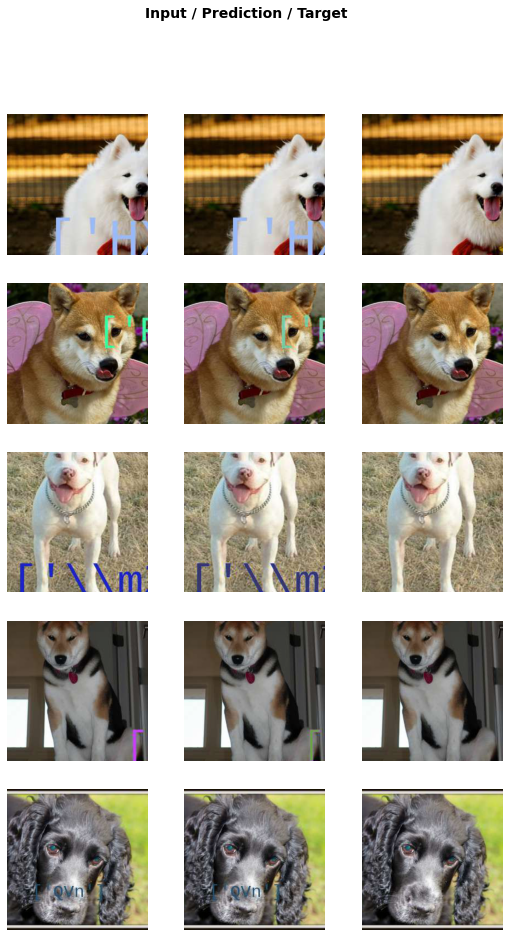

In [ ]:
do_fit(learn2, '2a', 5, slice(lr*10))

epoch,train_loss,valid_loss,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2,time
0,0.501657,0.573279,0.039233,0.037226,0.065956,0.048619,0.093466,0.169009,0.119769,08:08
1,0.506857,0.572198,0.039377,0.037131,0.065792,0.048518,0.093208,0.168643,0.119530,08:07
2,0.514060,0.571065,0.039355,0.037130,0.065734,0.048437,0.092996,0.168156,0.119259,08:07
3,0.514700,0.568815,0.039193,0.036969,0.065463,0.048248,0.092639,0.167488,0.118815,08:07
4,0.482850,0.567209,0.038697,0.036775,0.065173,0.048111,0.092656,0.167183,0.118613,08:07


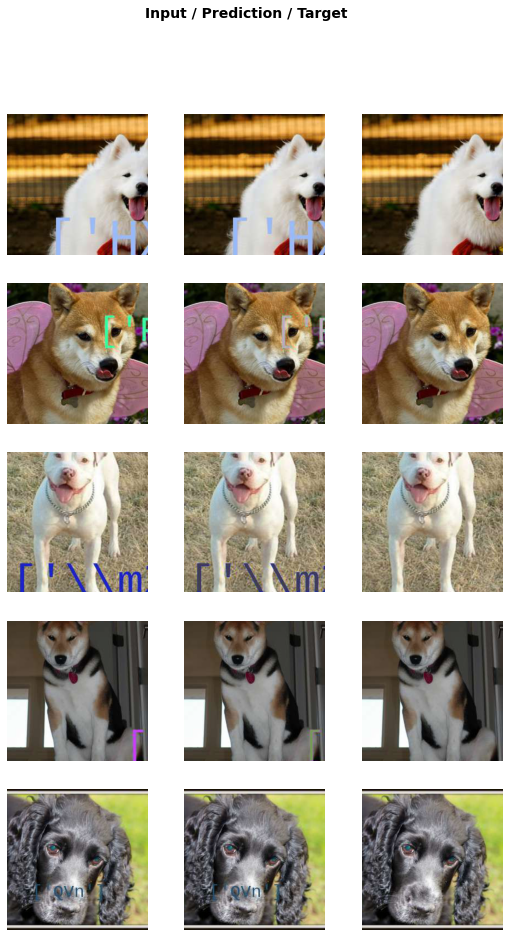

In [ ]:
learn2.unfreeze()
do_fit(learn2, '2b', 5, slice(1e-5,lr))

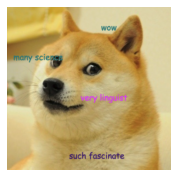

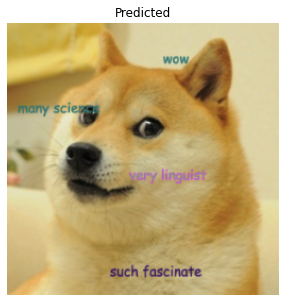

In [ ]:
compare(learn2, "https://blogs.unimelb.edu.au/sciencecommunication/files/2016/10/my-doge-zzb6qh-300x300.png")

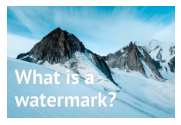

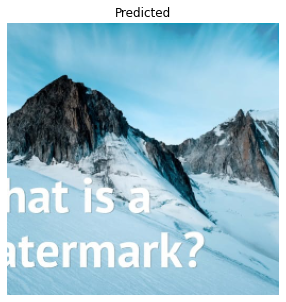

In [ ]:
compare(learn2,"https://www.visualwatermark.com/images/posts/what-is-a-watermark.jpg")